In [2]:
from laurel import mdp, control, graph_utils
import numpy as np
import jax.numpy as jnp
import jax
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from oetils.plotting import init_plotting

In [3]:
W = init_plotting(latex=True)
rng = np.random.default_rng(42)
key = jax.random.PRNGKey(42)

In [4]:
# Initialize training MDP.
env = mdp.MiddleMileMDP(
    num_hubs=10,
    timesteps=50,
    num_trucks_per_step=10,
    max_truck_duration=5,
    num_parcels=200,
    mean_route_length=10,
    cut_capacities=0,
    unit_weights=True,
    unit_capacities=True,
)

In [5]:
# Train linear policy with supervised learning.
controller = control.SupervisedController(rng, key, env, 'linear', 10, 10, 1)
losses = controller.train()

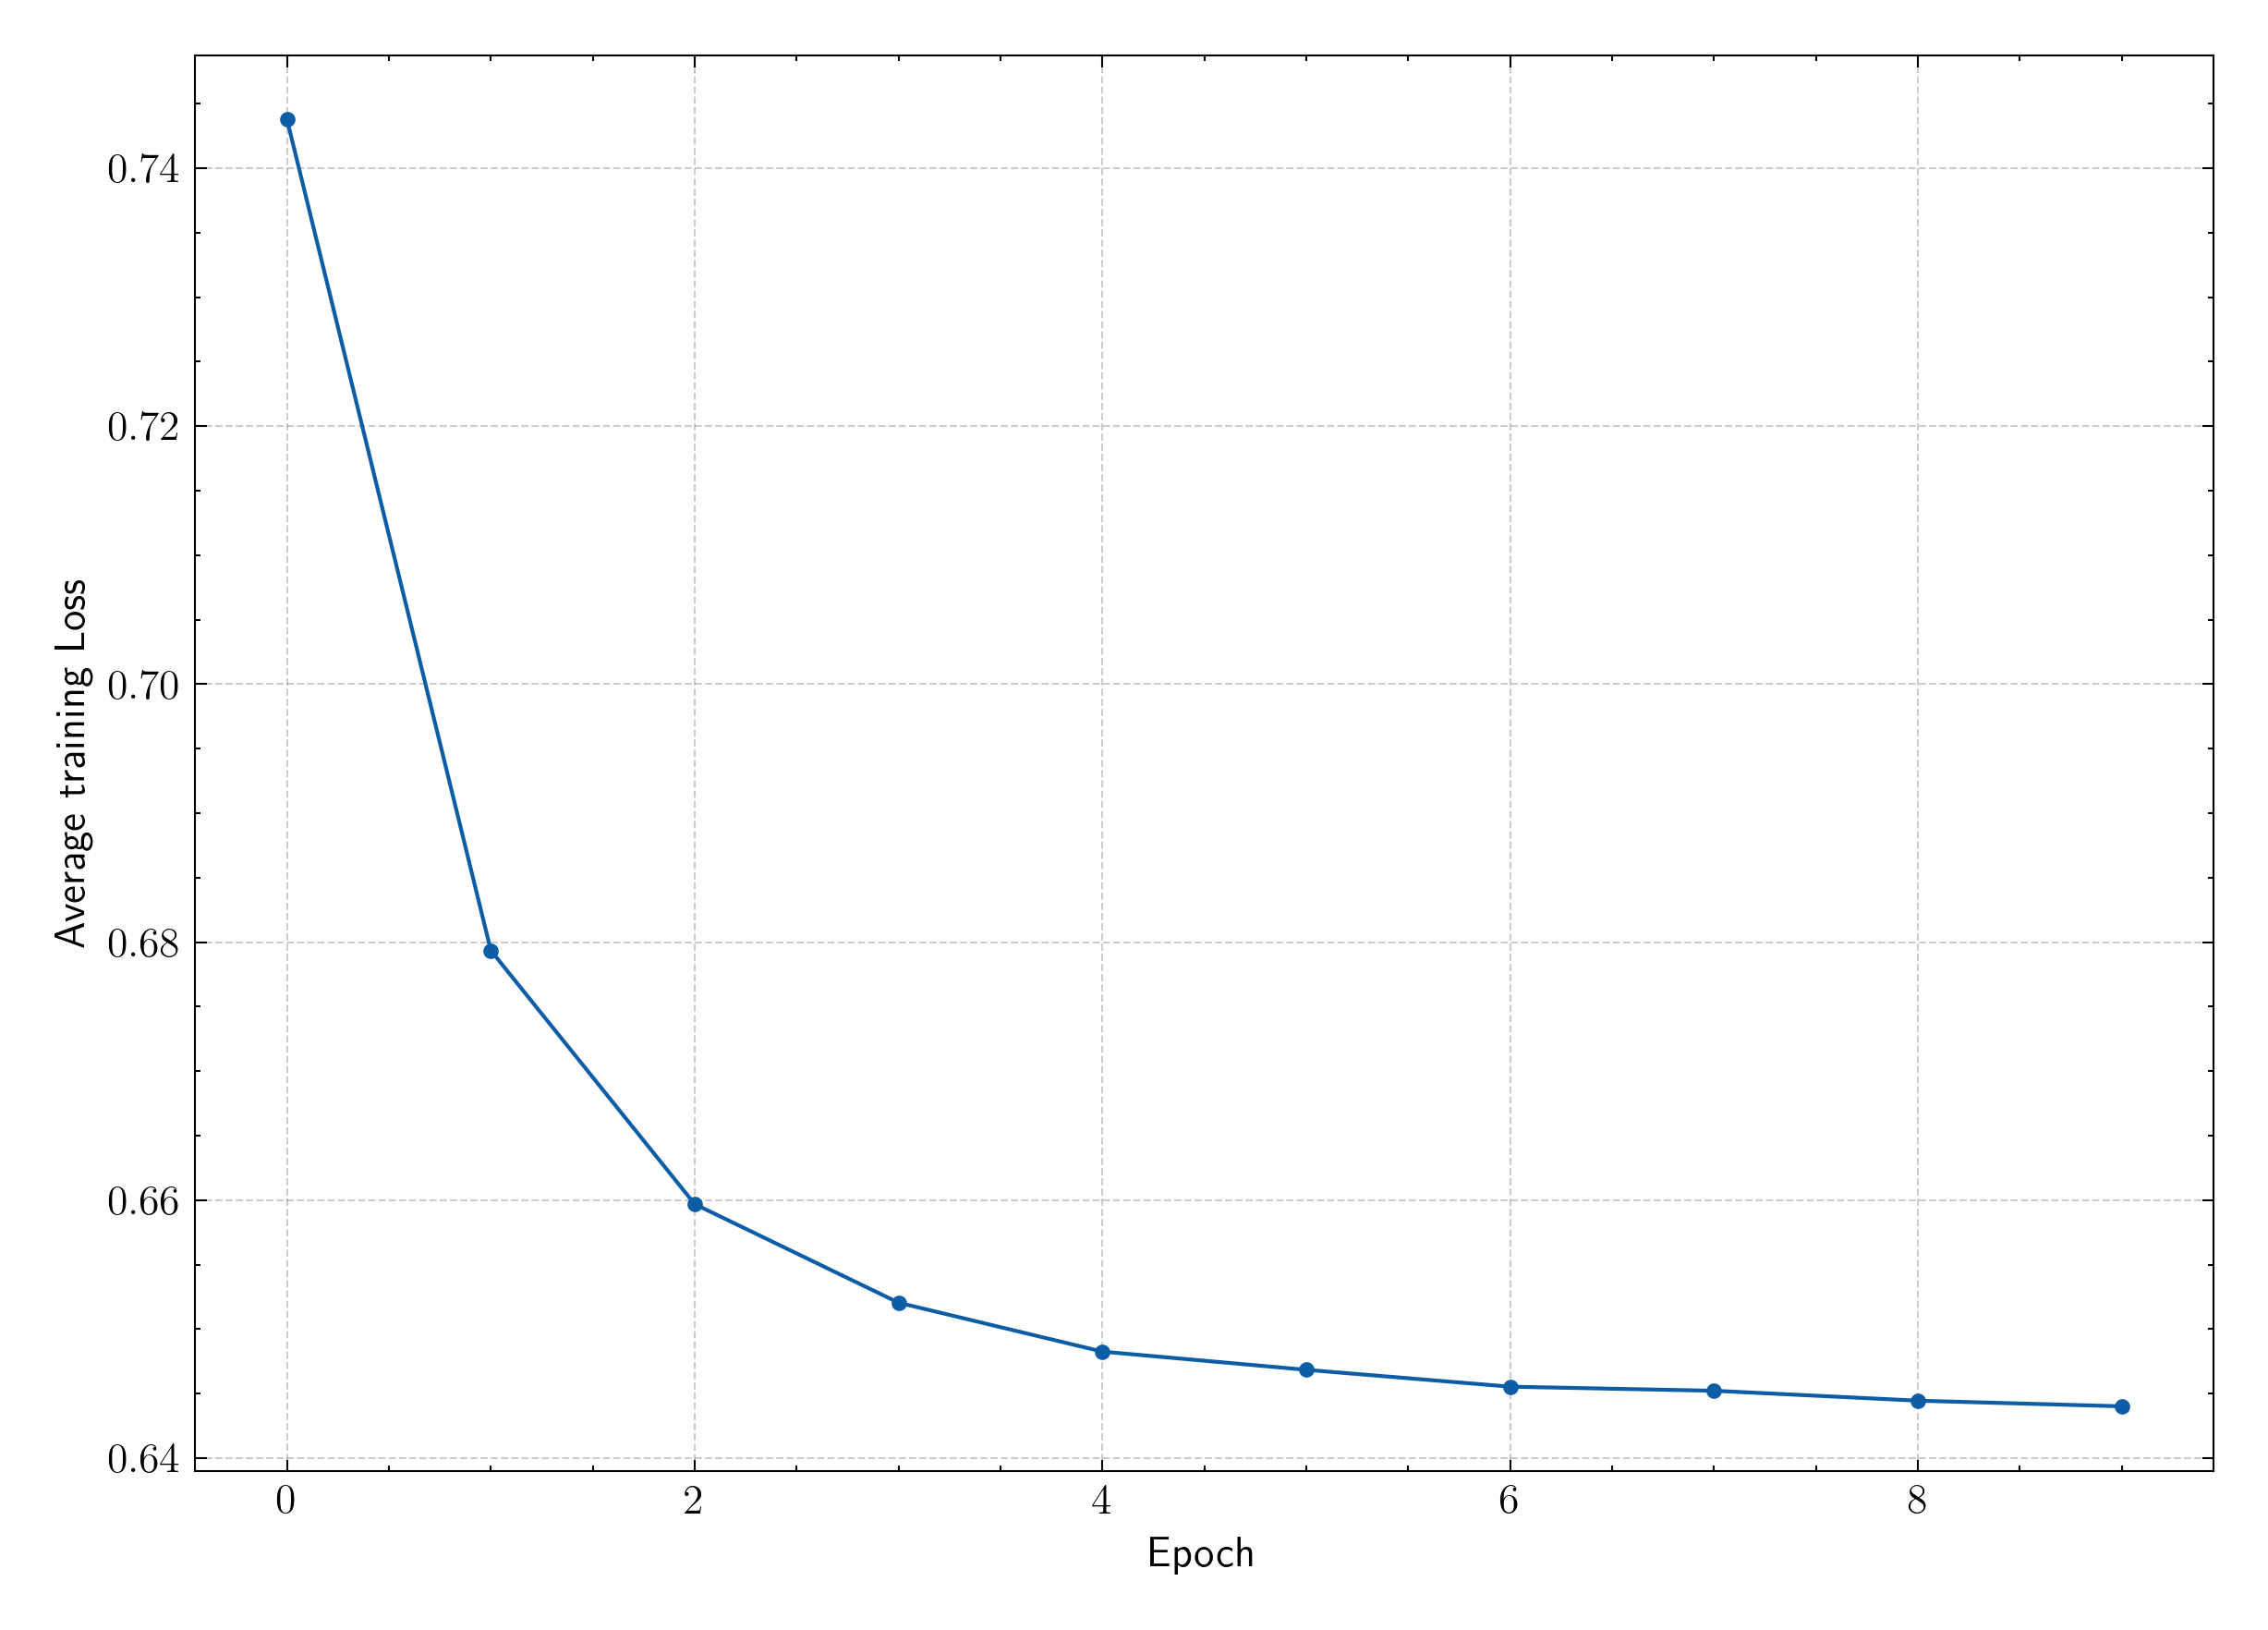

In [6]:
# Plot training curve.
fig, ax = plt.subplots()
ax.set_ylabel('Average training Loss')
ax.set_xlabel('Epoch')
ax.plot(losses, '.-')

In [7]:
# Linear SL vs. Greedy vs. Random policies.
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5
linear_perf = np.zeros((len(nums_parcels), num_trials))
greedy_perf = np.zeros((len(nums_parcels), num_trials))
random_perf = np.zeros((len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_parcels in enumerate(tqdm(nums_parcels)):
    for j in trange(num_trials, leave=False):
        # Create middle-mile environment and initialize state.
        env = mdp.MiddleMileMDP(
            num_hubs=10,
            timesteps=50,
            num_trucks_per_step=10,
            max_truck_duration=5,
            num_parcels=num_parcels,
            mean_route_length=10,
            cut_capacities=0,
            unit_weights=True,
            unit_capacities=True,
        )
        init_state, _ = env.reset(rng)

        # Linear SL
        state = init_state
        deliveries = 0
        while True:
            # Get next parcel and available trucks.
            state, parcel, truck = controller.act(state)
            if parcel is None:
                break

            # Put parcel onto truck, get next state.
            state, delivery, _ = env.step(parcel, truck, state, prune=False)
            deliveries += delivery

        linear_perf[i, j] = deliveries / num_parcels

        # Greedy
        state = init_state
        deliveries = 0
        while True:
            # Get next parcel and available trucks.
            state, feature_graph, parcel, trucks = env.get_feature_graph(
                1, state, min_phantom_weight=None, prune_parcel=False
            )
            if parcel is None:
                break
            parcel = parcel[0]

            # Put parcel onto greedy truck, get next state.
            truck_ids = list(trucks.keys())
            truck = trucks[truck_ids[np.argmin(
                feature_graph.nodes[feature_graph.receivers[truck_ids]][:, 2]
            )]]
            state, delivery, _ = env.step(parcel, truck, state, prune=False)
            deliveries += delivery

        greedy_perf[i, j] = deliveries / num_parcels

        # Random
        state = init_state
        deliveries = 0
        while True:
            # Get next parcel and available trucks.
            state, parcel, trucks = env.get_actions(state, prune_parcel=False)
            if parcel is None:
                break

            # Put parcel onto random truck, get next state.
            truck = rng.choice(trucks)
            state, delivery, _ = env.step(parcel, truck, state, prune=False)
            deliveries += delivery

        random_perf[i, j] = deliveries / num_parcels

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

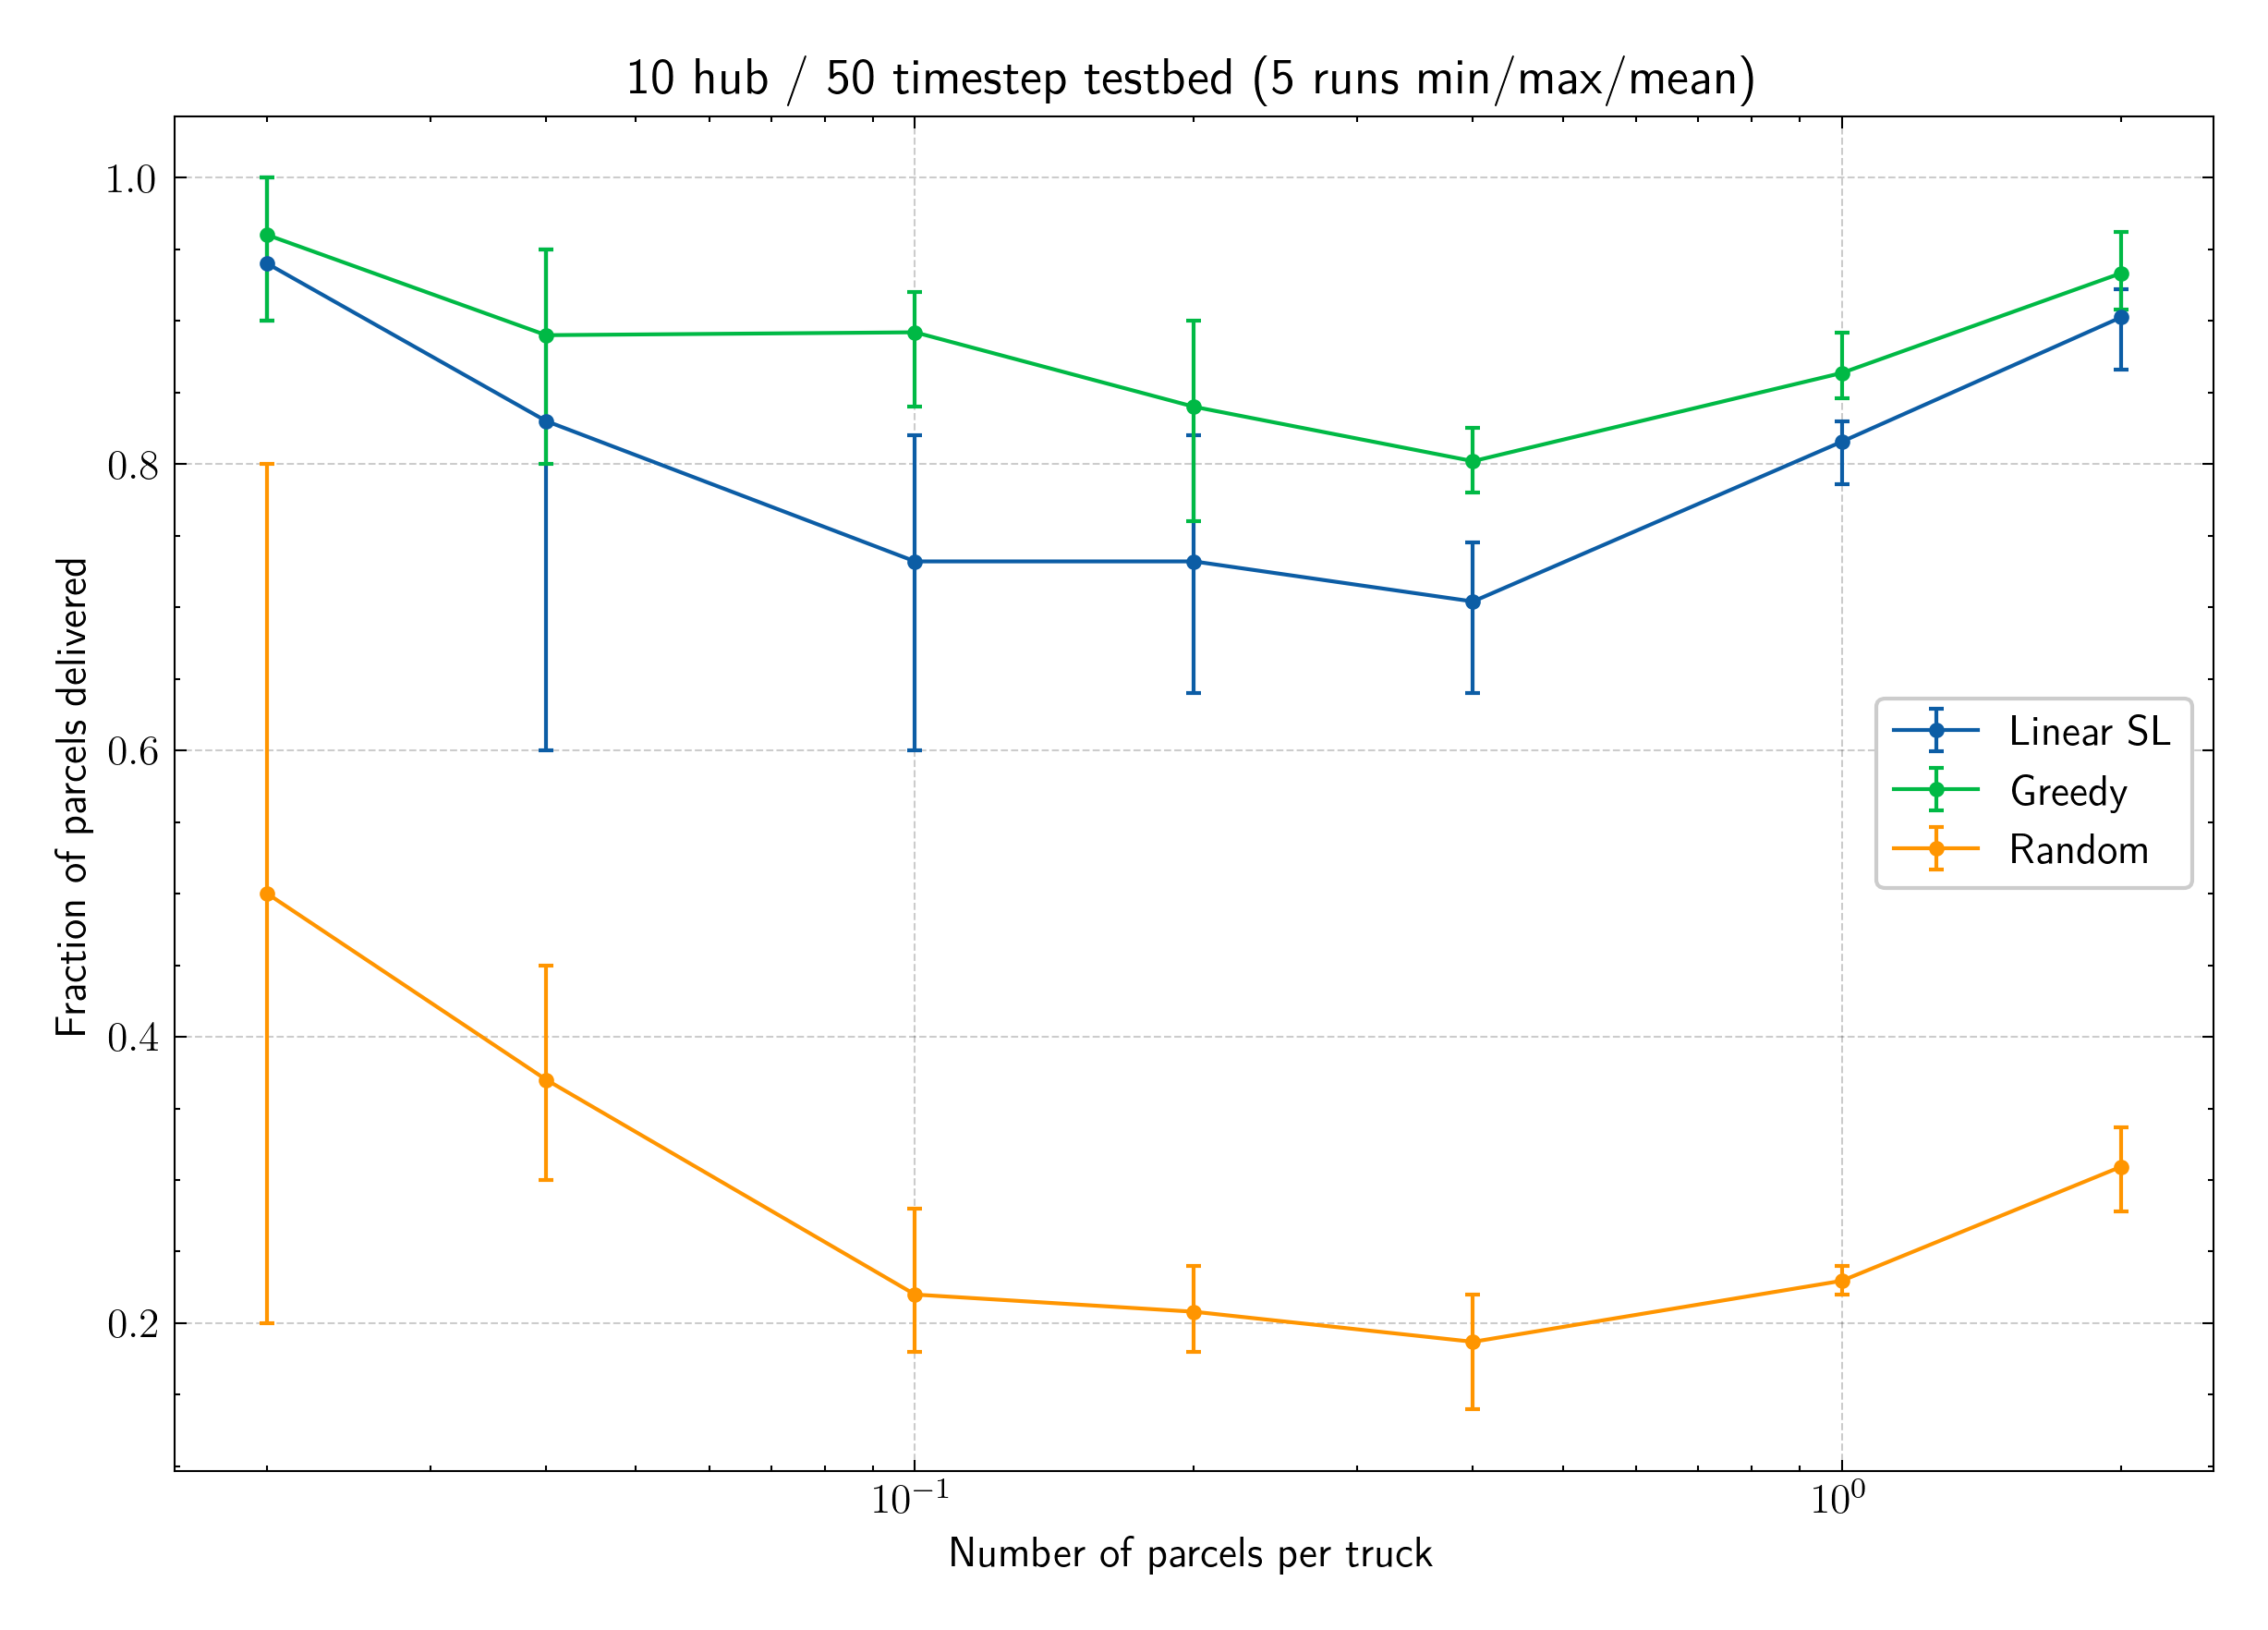

In [8]:
# Plot performances.
fig, ax = plt.subplots()
ax.set_title("10 hub / 50 timestep testbed (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels per truck")
ax.set_ylabel("Fraction of parcels delivered")
ax.set_xscale('log')
num_hubs = 10
timesteps = 50
parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
ax.errorbar(
    parcel_per_truck,
    np.nanmean(linear_perf, 1),
    np.stack([
        np.nanmean(linear_perf, 1) - np.nanmin(linear_perf, 1),
        np.nanmax(linear_perf, 1) - np.nanmean(linear_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Linear SL'
)
ax.errorbar(
    parcel_per_truck,
    np.nanmean(greedy_perf, 1),
    np.stack([
        np.nanmean(greedy_perf, 1) - np.nanmin(greedy_perf, 1),
        np.nanmax(greedy_perf, 1) - np.nanmean(greedy_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Greedy'
)
ax.errorbar(
    parcel_per_truck,
    np.nanmean(random_perf, 1),
    np.stack([
        np.nanmean(random_perf, 1) - np.nanmin(random_perf, 1),
        np.nanmax(random_perf, 1) - np.nanmean(random_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Random'
)
ax.legend()